In [1]:
import numpy as np
import argparse
import time
# The mnist library is from https://gist.github.com/akesling/5358964 and provides functions to 
# read MNIST into numpy arrays for processing.
from mnist import read, show

In [2]:
# read array of tuples of arrays
training_data_orig = list(read(dataset='training', path='.'))

./train-images-idx3-ubyte


In [3]:
# reads and binarizes 500 images
training_data = training_data_orig[:500]
labels, imgs = zip(*training_data)
training_binarized = (np.array(imgs)/255 > 0.5).astype(int)
training_binarized = training_binarized*2 - 1

In [4]:
# introduces 2% noise into each binarized image
training_noisy = np.copy(training_binarized)
# flip 16 values in each image
for i in range(len(training_binarized)):
    for count in range(16):
        row = np.random.randint(0,28)
        col = np.random.randint(0,28)
        training_noisy[i][row][col] = -1 * training_binarized[i][row][col]

In [5]:
theta_hi_xj = 2
theta_hi_hj = 0.2
def boltzmann(img, c):
    res = np.random.rand(28,28)
    for a in range(20):
        for i in range(len(img)):
            for j in range(len(img[0])):

                inner = 0
                if j > 0:
                    inner += c*(2*res[i][j-1] - 1) + theta_hi_xj*img[i][j-1]

                if j < len(img[0])-1:
                    inner += c*(2*res[i][j+1] - 1) + theta_hi_xj*img[i][j+1]

                if i > 0:
                    inner += c*(2*res[i-1][j] - 1) + theta_hi_xj*img[i-1][j]

                if i < len(img)-1:
                    inner += c*(2*res[i+1][j] - 1) + theta_hi_xj*img[i+1][j]
#                 print(inner)
                res[i][j] = np.exp(inner) / (np.exp(-1*inner) + np.exp(inner))

    return res # table of pi probabilities

In [6]:
def boltzmann_parallel(imgs,c):
    result = np.empty(np.shape(training_noisy))
    for i in range(len(result)):
        print(i)
        result[i] = boltzmann(imgs[i], c)
    return result

In [7]:

training_denoised = np.empty(np.shape(training_noisy))
# for i in range(len(training_noisy)):
#     print(i)
#     temp = boltzmann(training_noisy[i], 0.2)
#     training_denoised[i] = temp
# map(boltzmann, training_noisy, 0.2)

In [8]:
# denoise all 500 images in parallel
from multiprocessing import Process, Pool
pool = Pool(7)
results_array = pool.starmap(boltzmann_parallel, [(training_binarized, -1),(training_binarized, -0.6),(training_binarized, -0.2),(training_binarized, 0),(training_binarized, 0.2),(training_binarized, 0.6),(training_binarized, 1)])
# results array = denoised images with values of c= -1, -0.6, -0.2, 0, 0.2(default), 0.6, 1


0
0
0
0
0
0
0
1
1
1
1
1
1
1
2
2
2
2
2
2
2
3
3
3
3
3
4
3
4
3
4
4
4
4
5
5
4
5
5
5
6
6
5
5
6
6
7
6
7
7
6
6
7
8
8
7
8
8
7
7
9
9
9
8
9
8
10
8
10
9
10
10
11
9
11
10
9
11
12
11
12
10
13
11
10
12
14
12
13
11
12
13
11
15
13
13
14
12
16
14
12
14
17
14
15
13
13
15
18
15
15
16
14
16
19
14
16
20
16
15
17
17
21
15
17
22
17
16
18
18
16
18
18
23
17
19
19
24
19
17
19
20
25
18
20
20
18
26
20
21
21
19
21
19
27
21
22
20
22
28
22
20
21
23
22
29
23
22
23
21
23
24
30
23
24
24
24
22
23
31
25
24
25
25
25
32
26
24
26
26
25
26
27
27
33
27
25
26
27
28
28
28
34
26
27
29
28
35
29
29
27
28
30
36
29
30
30
31
28
29
37
32
30
31
31
33
29
30
38
32
34
32
31
31
30
39
35
33
33
32
32
36
31
40
34
37
34
33
33
32
41
38
35
35
34
34
39
33
42
36
35
36
35
34
37
40
43
36
37
38
36
35
41
44
38
39
37
37
45
40
42
39
36
38
41
46
40
38
43
37
41
42
39
47
39
44
43
38
42
40
48
44
40
45
39
43
45
41
49
41
46
46
40
44
47
42
42
47
50
45
41
48
43
46
43
48
51
49
42
50
47
44
49
44
52
51
43
48
52
45
50
53
45
53
44
49
46
51
54
46
54
45
55
50
55
47
47

In [9]:
# binarize denoised images
training_denoised = results_array[4] # for the default c=0.2 case
training_denoised_bin = np.empty(np.shape(training_noisy))
for i in range(len(training_denoised)):
    for row in range(len(training_denoised[i])):
        for col in range(len(training_denoised[i][0])):
            if training_denoised[i][row][col] > 0.5:
                training_denoised[i][row][col] = 255
                training_denoised_bin[i][row][col] = 1
            else:
                training_denoised[i][row][col] = 0
                training_denoised_bin[i][row][col] = -1

In [10]:
# calculates different pixels in all images
fraction = np.sum(np.abs(training_denoised_bin - training_binarized)) / (2 * 500 * (28 ** 2))
print(1-fraction) # percentage of correct pixels

0.984341836735


In [11]:
recons = np.abs(training_denoised_bin - training_binarized)
zipped = zip(training_denoised_bin, training_binarized, recons)
zipped_s = sorted(zipped, key=lambda x: np.count_nonzero(x[2]))

#### Most accurate reconstruction

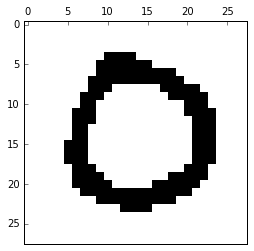

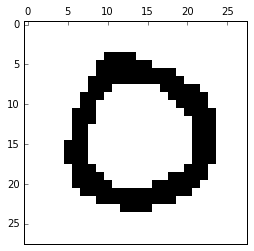

In [15]:
show(zipped_s[0][1]) # most accurate training image
show(zipped_s[0][0]) # most accurate reconstruction

#### Least accurate reconstruction

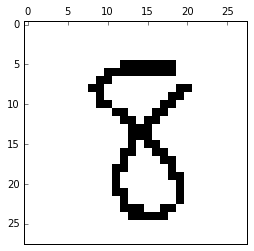

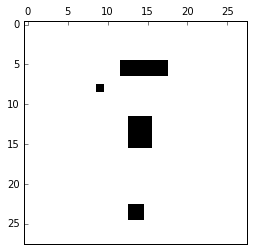

In [13]:
show(zipped_s[-1][1]) # least accurate training image
show(zipped_s[-1][0]) # least accurate reconstruction

## Receiver Operating Curves

In [19]:
roc_tpr = []
roc_fpr = []

for i in range(500):
    numCorrect = 0
    numFalse = 0
    numTrueBlack = 0
    numTrueWhite = 0
    for j in range(28):
        for k in range(28):
            if training_binarized[i,j,k] == 1:
                numTrueBlack += 1
                if training_denoised_bin[i,j,k] == 1:
                    numCorrect += 1
            else:
                numTrueWhite += 1
                if training_denoised_bin[i,j,k] == 1:
                    numFalse += 1
    roc_tpr.append(float(numCorrect)/float(numTrueBlack))
    roc_fpr.append(float(numFalse)/(numTrueWhite))

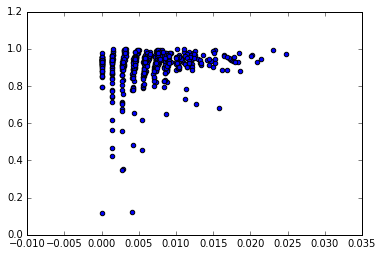

In [24]:
import matplotlib.pyplot as plt
plt.scatter(roc_fpr, roc_tpr)
plt.show()